**Description:** <br>
Here we try to predict the ETA at a future waypoint or final destination, for flights from ORY to TLS airports. The LSTM network has been trained on the flight data from ORY to TLS using the timestamps in epoch format. In this version we set the number of time steps (lag) to be shifted (`n_in` >= **10**) in the `series_to_supervised` function and predict the latitude and longitude

* __Author__: Dilip Rajkumar

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

# Set Random Seed for reproducible results
np.random.seed(42)

#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=3, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.8g" % x))

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from math import sqrt

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
%matplotlib inline

In [4]:
df = pd.read_csv('data/ADSB_SampleData.csv',parse_dates = ['postime'])
cols_of_interest = ['postime','aircraftreg','icao','lat','lon','alt','course','speed','verticalspeed']
flightpaths = df.groupby(['fromairport']).get_group('ORY')[cols_of_interest]
flightpaths.head()

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
1,1539414114000,F-GKXE,3746532,48.729340,2.35702,0,128,0,0
5,1539414140000,F-GTAP,3755023,44.218559,1.60048,12425,215,349,-1664
21,1539414147000,F-GTAP,3755023,44.211040,1.59303,12250,215,346,-1664
25,1539414149000,F-GTAP,3755023,44.207119,1.58909,12175,215,346,-1600
39,1539414154000,F-GKXE,3746532,48.729351,2.35701,0,309,0,0


In [5]:
flightpaths[['postime']] = flightpaths[['postime']].apply(pd.to_numeric)
flightpaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11904 entries, 1 to 97971
Data columns (total 9 columns):
postime          11904 non-null int64
aircraftreg      11904 non-null object
icao             11904 non-null int64
lat              11904 non-null float64
lon              11904 non-null float64
alt              11904 non-null int64
course           11904 non-null int64
speed            11904 non-null int64
verticalspeed    11904 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 930.0+ KB


In [6]:
# Check for Duplicates in the Dataframe
flightpaths[flightpaths.duplicated(subset=['postime','icao','lat','lon'])]

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
59,1539414158000,F-GKXE,3746532,48.729340,2.35701,0,309,0,0
88,1539414164000,F-GKXE,3746532,48.729351,2.35702,0,89,0,0
109,1539414173000,F-GTAP,3755023,44.177410,1.55975,11375,215,342,-2496
153,1539414187000,F-GTAP,3755023,44.159729,1.54224,11025,215,336,-1088
157,1539414185000,F-GKXE,3746532,48.729340,2.35703,0,130,0,0
265,1539414230000,F-GKXE,3746532,48.729340,2.35702,0,271,0,0
373,1539414270000,F-GKXE,3746532,48.729340,2.35701,0,309,0,0
420,1539414284000,F-GKXE,3746532,48.729351,2.35702,0,89,0,0
435,1539414292000,F-GTAP,3755023,44.044289,1.41678,8775,227,283,-2112
457,1539414294000,F-GKXE,3746532,48.729340,2.35703,0,89,0,0


In [7]:
flightpaths.drop_duplicates(keep='first', inplace=True)
flightpaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9739 entries, 1 to 97971
Data columns (total 9 columns):
postime          9739 non-null int64
aircraftreg      9739 non-null object
icao             9739 non-null int64
lat              9739 non-null float64
lon              9739 non-null float64
alt              9739 non-null int64
course           9739 non-null int64
speed            9739 non-null int64
verticalspeed    9739 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 760.9+ KB


In [8]:
# Grouping and sorting by ICAO values and postime
flightpaths.sort_values(by=['icao','postime'], inplace = True)
flightpaths.tail()

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
90170,1539411476000,OE-IJY,4457132,43.627281,1.37124,0,323,33,0
90183,1539411482000,OE-IJY,4457132,43.627560,1.37093,0,323,33,0
90394,1539411541000,OE-IJY,4457132,43.629581,1.37286,0,42,21,0
90456,1539411557000,OE-IJY,4457132,43.629860,1.37323,0,42,12,0
90444,1539411562000,OE-IJY,4457132,43.629890,1.37325,0,42,11,0


In [9]:
flightpaths.reset_index(drop=True, inplace = True)
flightpaths.head()

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
0,1539410352000,F-GKXE,3746532,48.729328,2.35702,0,31,0,0
1,1539410362000,F-GKXE,3746532,48.729309,2.35701,0,212,0,0
2,1539410381000,F-GKXE,3746532,48.729321,2.35702,0,128,0,0
3,1539410386000,F-GKXE,3746532,48.729309,2.35702,0,131,0,0
4,1539410398000,F-GKXE,3746532,48.729301,2.35701,0,247,0,0


In [10]:
print('No. of unique Aircraft Registrations:',flightpaths.aircraftreg.nunique())

No. of unique Aircraft Registrations: 12


In [11]:
print("No. of Unique Airline Carriers flying from ORY to TLS:",flightpaths.aircraftreg.nunique())
print("No. of Unique ICAOs flying from ORY to TLS:",flightpaths.icao.nunique())

No. of Unique Airline Carriers flying from ORY to TLS: 12
No. of Unique ICAOs flying from ORY to TLS: 12


In [12]:
print("Unique ICAOs flying from ORY to TLS:",flightpaths.icao.unique(),"\n")
print("Unique Airline Carriers flying from ORY to TLS:",flightpaths.aircraftreg.unique())

Unique ICAOs flying from ORY to TLS: [3746532 3751299 3753188 3753192 3753697 3755023 3756228 3769765 3769768 3769770 4221197 4457132] 

Unique Airline Carriers flying from ORY to TLS: ['F-GKXE' 'F-GPMD' 'F-GRHE' 'F-GRHI' 'F-GRXB' 'F-GTAP' 'F-GUGE' 'F-HBNF' 'F-HBNI' 'F-HBNK' 'G-EZWL' 'OE-IJY']


In [13]:
# Check for Duplicates in the Dataframe
flightpaths[flightpaths.duplicated(subset=['postime','icao','lat','lon'])]

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed


In [14]:
flightpaths.iloc[6779]

postime          1539456573000
aircraftreg             F-HBNI
icao                   3769768
lat                    43.6292
lon                    1.37537
alt                          0
course                       8
speed                        2
verticalspeed                0
Name: 6779, dtype: object

### Data Pre-Processing and Feature Extraction:

In [15]:
# Drop Categorical Columns not needed for the neural network
df_nn = flightpaths.copy()
df_nn.drop(columns=['aircraftreg','icao'],inplace = True)
df_nn.head()

,postime,lat,lon,alt,course,speed,verticalspeed
0,1539410352000,48.729328,2.35702,0,31,0,0
1,1539410362000,48.729309,2.35701,0,212,0,0
2,1539410381000,48.729321,2.35702,0,128,0,0
3,1539410386000,48.729309,2.35702,0,131,0,0
4,1539410398000,48.729301,2.35701,0,247,0,0


In [16]:
# Check for NULL values across on column or row
df_nn[df_nn.isnull().any(axis=1)]

,postime,lat,lon,alt,course,speed,verticalspeed


In [17]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag (t-n) observations as input (X). Defaults to 1
        n_out: Number of lead (t + n) observations as output (y). Defaults to 1, that is var(t)
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
# load dataset vales
values = df_nn.values

# frame as supervised learning with raw values
reframed_raw = series_to_supervised(values, 10, 1)

# drop columns we don't want to predict
reframed_raw.drop(reframed_raw.columns[[71,72,73,74,75,76]], axis=1, inplace=True)
reframed_raw.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var1(t-9),var2(t-9),var3(t-9),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
10,1.539410e+12,48.729328,2.35702,0.0,31.0,0.0,0.0,1.539410e+12,48.729309,2.35701,...,0.0,0.0,1.539410e+12,48.729301,2.35703,0.0,66.0,0.0,0.0,1.539410e+12
11,1.539410e+12,48.729309,2.35701,0.0,212.0,0.0,0.0,1.539410e+12,48.729321,2.35702,...,0.0,0.0,1.539410e+12,48.729321,2.35702,0.0,66.0,0.0,0.0,1.539410e+12
12,1.539410e+12,48.729321,2.35702,0.0,128.0,0.0,0.0,1.539410e+12,48.729309,2.35702,...,0.0,0.0,1.539410e+12,48.729321,2.35703,0.0,130.0,0.0,0.0,1.539410e+12
13,1.539410e+12,48.729309,2.35702,0.0,131.0,0.0,0.0,1.539410e+12,48.729301,2.35701,...,0.0,0.0,1.539410e+12,48.729321,2.35703,0.0,311.0,0.0,0.0,1.539411e+12
14,1.539410e+12,48.729301,2.35701,0.0,247.0,0.0,0.0,1.539410e+12,48.729309,2.35701,...,0.0,0.0,1.539411e+12,48.729309,2.35702,0.0,210.0,0.0,0.0,1.539411e+12


In [19]:
## Using Label encoder for any categorical variables
# encoder = LabelEncoder()
# values[:,x] = encoder.fit_transform(values[:,x])

# ensure all data is float
values = values.astype('float32')
values.shape # Has the same number of columns as flightpath columns

(9739, 7)

In [20]:
# Normalize features with separate MinMaxScaler for inputs and outputs
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_inputs = scaler_x.fit_transform(values[:,1:])
scaled_output = scaler_y.fit_transform(values[:, :1])
scaled = np.concatenate((scaled_output,scaled_inputs), axis=1)

In [21]:
# frame as supervised learning with scaled values time shifted to 10 steps
lag_steps = 10 # n_in value given as input attribute to series_to_supervised function
reframed = series_to_supervised(scaled, lag_steps, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[71,72,73,74,75,76]], axis=1, inplace=True)

reframed.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var1(t-9),var2(t-9),var3(t-9),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
10,0.058594,0.997078,0.817607,0.0,0.084270,0.0,0.563291,0.058594,0.997074,0.817600,...,0.0,0.563291,0.060547,0.997073,0.817614,0.0,0.182584,0.0,0.563291,0.060547
11,0.058594,0.997074,0.817600,0.0,0.592697,0.0,0.563291,0.058594,0.997077,0.817607,...,0.0,0.563291,0.060547,0.997077,0.817607,0.0,0.182584,0.0,0.563291,0.060547
12,0.058594,0.997077,0.817607,0.0,0.356742,0.0,0.563291,0.058594,0.997074,0.817607,...,0.0,0.563291,0.060547,0.997077,0.817614,0.0,0.362360,0.0,0.563291,0.060547
13,0.058594,0.997074,0.817607,0.0,0.365169,0.0,0.563291,0.058594,0.997073,0.817600,...,0.0,0.563291,0.060547,0.997077,0.817614,0.0,0.870787,0.0,0.563291,0.060547
14,0.058594,0.997073,0.817600,0.0,0.691011,0.0,0.563291,0.058594,0.997074,0.817600,...,0.0,0.563291,0.060547,0.997074,0.817607,0.0,0.587079,0.0,0.563291,0.060547


In [22]:
values = reframed.values
print(values.shape)

(9729, 71)


In [23]:
# Manually defining row split number which is equal last row of same flight and also roughly split at 70% of the data available
train_test_split_row_nr = 6779 

# split into train and test sets
train = values[:train_test_split_row_nr, :]
test = values[train_test_split_row_nr:, :]
print(train.shape, test.shape)

(6779, 71) (2950, 71)


In [24]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:,-1:]
test_X, test_y = test[:, :-1], test[:, -1:]
print(train_X.shape,train_y.shape, test_X.shape, test_y.shape)

(6779, 70) (6779, 1) (2950, 70) (2950, 1)


In [25]:
n_features = 7
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], lag_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6779, 10, 7) (6779, 1) (2950, 10, 7) (2950, 1)


In [26]:
%%time
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=1,shuffle=False)

Train on 6779 samples, validate on 2950 samples
Epoch 1/500
6779/6779 [==============================] - 2s 310us/step - loss: 0.1925 - val_loss: 0.3037
Epoch 2/500
6779/6779 [==============================] - 1s 145us/step - loss: 0.1654 - val_loss: 0.2183
Epoch 3/500
6779/6779 [==============================] - 1s 128us/step - loss: 0.1252 - val_loss: 0.1777
Epoch 4/500
6779/6779 [==============================] - 1s 134us/step - loss: 0.0819 - val_loss: 0.1439
Epoch 5/500
6779/6779 [==============================] - 1s 165us/step - loss: 0.0721 - val_loss: 0.0927
Epoch 6/500
6779/6779 [==============================] - 1s 120us/step - loss: 0.0628 - val_loss: 0.0553
Epoch 7/500
6779/6779 [==============================] - 1s 114us/step - loss: 0.0567 - val_loss: 0.0953
Epoch 8/500
6779/6779 [==============================] - 1s 153us/step - loss: 0.0479 - val_loss: 0.0360
Epoch 9/500
6779/6779 [==============================] - 2s 236us/step - loss: 0.0321 - val_loss: 0.1021
Epoch 1

6779/6779 [==============================] - 1s 113us/step - loss: 0.0147 - val_loss: 0.0107
Epoch 78/500
6779/6779 [==============================] - 1s 143us/step - loss: 0.0126 - val_loss: 0.0400
Epoch 79/500
6779/6779 [==============================] - 1s 128us/step - loss: 0.0175 - val_loss: 0.0168
Epoch 80/500
6779/6779 [==============================] - 1s 116us/step - loss: 0.0180 - val_loss: 0.0129
Epoch 81/500
6779/6779 [==============================] - 1s 123us/step - loss: 0.0161 - val_loss: 0.0063
Epoch 82/500
6779/6779 [==============================] - 1s 130us/step - loss: 0.0092 - val_loss: 0.0114
Epoch 83/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0139 - val_loss: 0.0347
Epoch 84/500
6779/6779 [==============================] - 1s 113us/step - loss: 0.0167 - val_loss: 0.0264
Epoch 85/500
6779/6779 [==============================] - 1s 114us/step - loss: 0.0098 - val_loss: 0.0110
Epoch 86/500
6779/6779 [==============================] - 1

Epoch 154/500
6779/6779 [==============================] - 1s 122us/step - loss: 0.0108 - val_loss: 0.0146
Epoch 155/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0088 - val_loss: 0.0279
Epoch 156/500
6779/6779 [==============================] - 1s 112us/step - loss: 0.0102 - val_loss: 0.0133
Epoch 157/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0104 - val_loss: 0.0180
Epoch 158/500
6779/6779 [==============================] - 1s 119us/step - loss: 0.0101 - val_loss: 0.0066
Epoch 159/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0105 - val_loss: 0.0110
Epoch 160/500
6779/6779 [==============================] - 1s 114us/step - loss: 0.0074 - val_loss: 0.0191
Epoch 161/500
6779/6779 [==============================] - 1s 122us/step - loss: 0.0125 - val_loss: 0.0161
Epoch 162/500
6779/6779 [==============================] - 1s 125us/step - loss: 0.0073 - val_loss: 0.0092
Epoch 163/500
6779/6779 [============

6779/6779 [==============================] - 1s 123us/step - loss: 0.0064 - val_loss: 0.0039
Epoch 231/500
6779/6779 [==============================] - 1s 129us/step - loss: 0.0090 - val_loss: 0.0053
Epoch 232/500
6779/6779 [==============================] - 1s 116us/step - loss: 0.0050 - val_loss: 0.0088
Epoch 233/500
6779/6779 [==============================] - 1s 115us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 234/500
6779/6779 [==============================] - 1s 116us/step - loss: 0.0099 - val_loss: 0.0116
Epoch 235/500
6779/6779 [==============================] - 1s 116us/step - loss: 0.0079 - val_loss: 0.0057
Epoch 236/500
6779/6779 [==============================] - 1s 111us/step - loss: 0.0068 - val_loss: 0.0039
Epoch 237/500
6779/6779 [==============================] - 1s 117us/step - loss: 0.0052 - val_loss: 0.0143
Epoch 238/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0097 - val_loss: 0.0129
Epoch 239/500
6779/6779 [==========================

6779/6779 [==============================] - 1s 114us/step - loss: 0.0060 - val_loss: 0.0051
Epoch 307/500
6779/6779 [==============================] - 1s 108us/step - loss: 0.0049 - val_loss: 0.0053
Epoch 308/500
6779/6779 [==============================] - 1s 109us/step - loss: 0.0056 - val_loss: 0.0102
Epoch 309/500
6779/6779 [==============================] - 1s 109us/step - loss: 0.0074 - val_loss: 0.0183
Epoch 310/500
6779/6779 [==============================] - 1s 109us/step - loss: 0.0097 - val_loss: 0.0046
Epoch 311/500
6779/6779 [==============================] - 1s 108us/step - loss: 0.0055 - val_loss: 0.0107
Epoch 312/500
6779/6779 [==============================] - 1s 108us/step - loss: 0.0058 - val_loss: 0.0129
Epoch 313/500
6779/6779 [==============================] - 1s 113us/step - loss: 0.0061 - val_loss: 0.0078
Epoch 314/500
6779/6779 [==============================] - 1s 108us/step - loss: 0.0071 - val_loss: 0.0144
Epoch 315/500
6779/6779 [==========================

6779/6779 [==============================] - 1s 125us/step - loss: 0.0051 - val_loss: 0.0120
Epoch 383/500
6779/6779 [==============================] - 1s 119us/step - loss: 0.0063 - val_loss: 0.0083
Epoch 384/500
6779/6779 [==============================] - 1s 128us/step - loss: 0.0064 - val_loss: 0.0111
Epoch 385/500
6779/6779 [==============================] - 1s 131us/step - loss: 0.0080 - val_loss: 0.0053
Epoch 386/500
6779/6779 [==============================] - 1s 128us/step - loss: 0.0040 - val_loss: 0.0061
Epoch 387/500
6779/6779 [==============================] - 1s 121us/step - loss: 0.0045 - val_loss: 0.0208
Epoch 388/500
6779/6779 [==============================] - 1s 122us/step - loss: 0.0090 - val_loss: 0.0198
Epoch 389/500
6779/6779 [==============================] - 1s 118us/step - loss: 0.0070 - val_loss: 0.0111
Epoch 390/500
6779/6779 [==============================] - 1s 110us/step - loss: 0.0070 - val_loss: 0.0041
Epoch 391/500
6779/6779 [==========================

6779/6779 [==============================] - 1s 121us/step - loss: 0.0066 - val_loss: 0.0057
Epoch 459/500
6779/6779 [==============================] - 1s 112us/step - loss: 0.0066 - val_loss: 0.0112
Epoch 460/500
6779/6779 [==============================] - 1s 117us/step - loss: 0.0052 - val_loss: 0.0051
Epoch 461/500
6779/6779 [==============================] - 1s 112us/step - loss: 0.0040 - val_loss: 0.0086
Epoch 462/500
6779/6779 [==============================] - 1s 140us/step - loss: 0.0072 - val_loss: 0.0060
Epoch 463/500
6779/6779 [==============================] - 1s 113us/step - loss: 0.0043 - val_loss: 0.0057
Epoch 464/500
6779/6779 [==============================] - 1s 113us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 465/500
6779/6779 [==============================] - 1s 113us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 466/500
6779/6779 [==============================] - 1s 110us/step - loss: 0.0049 - val_loss: 0.0070
Epoch 467/500
6779/6779 [==========================

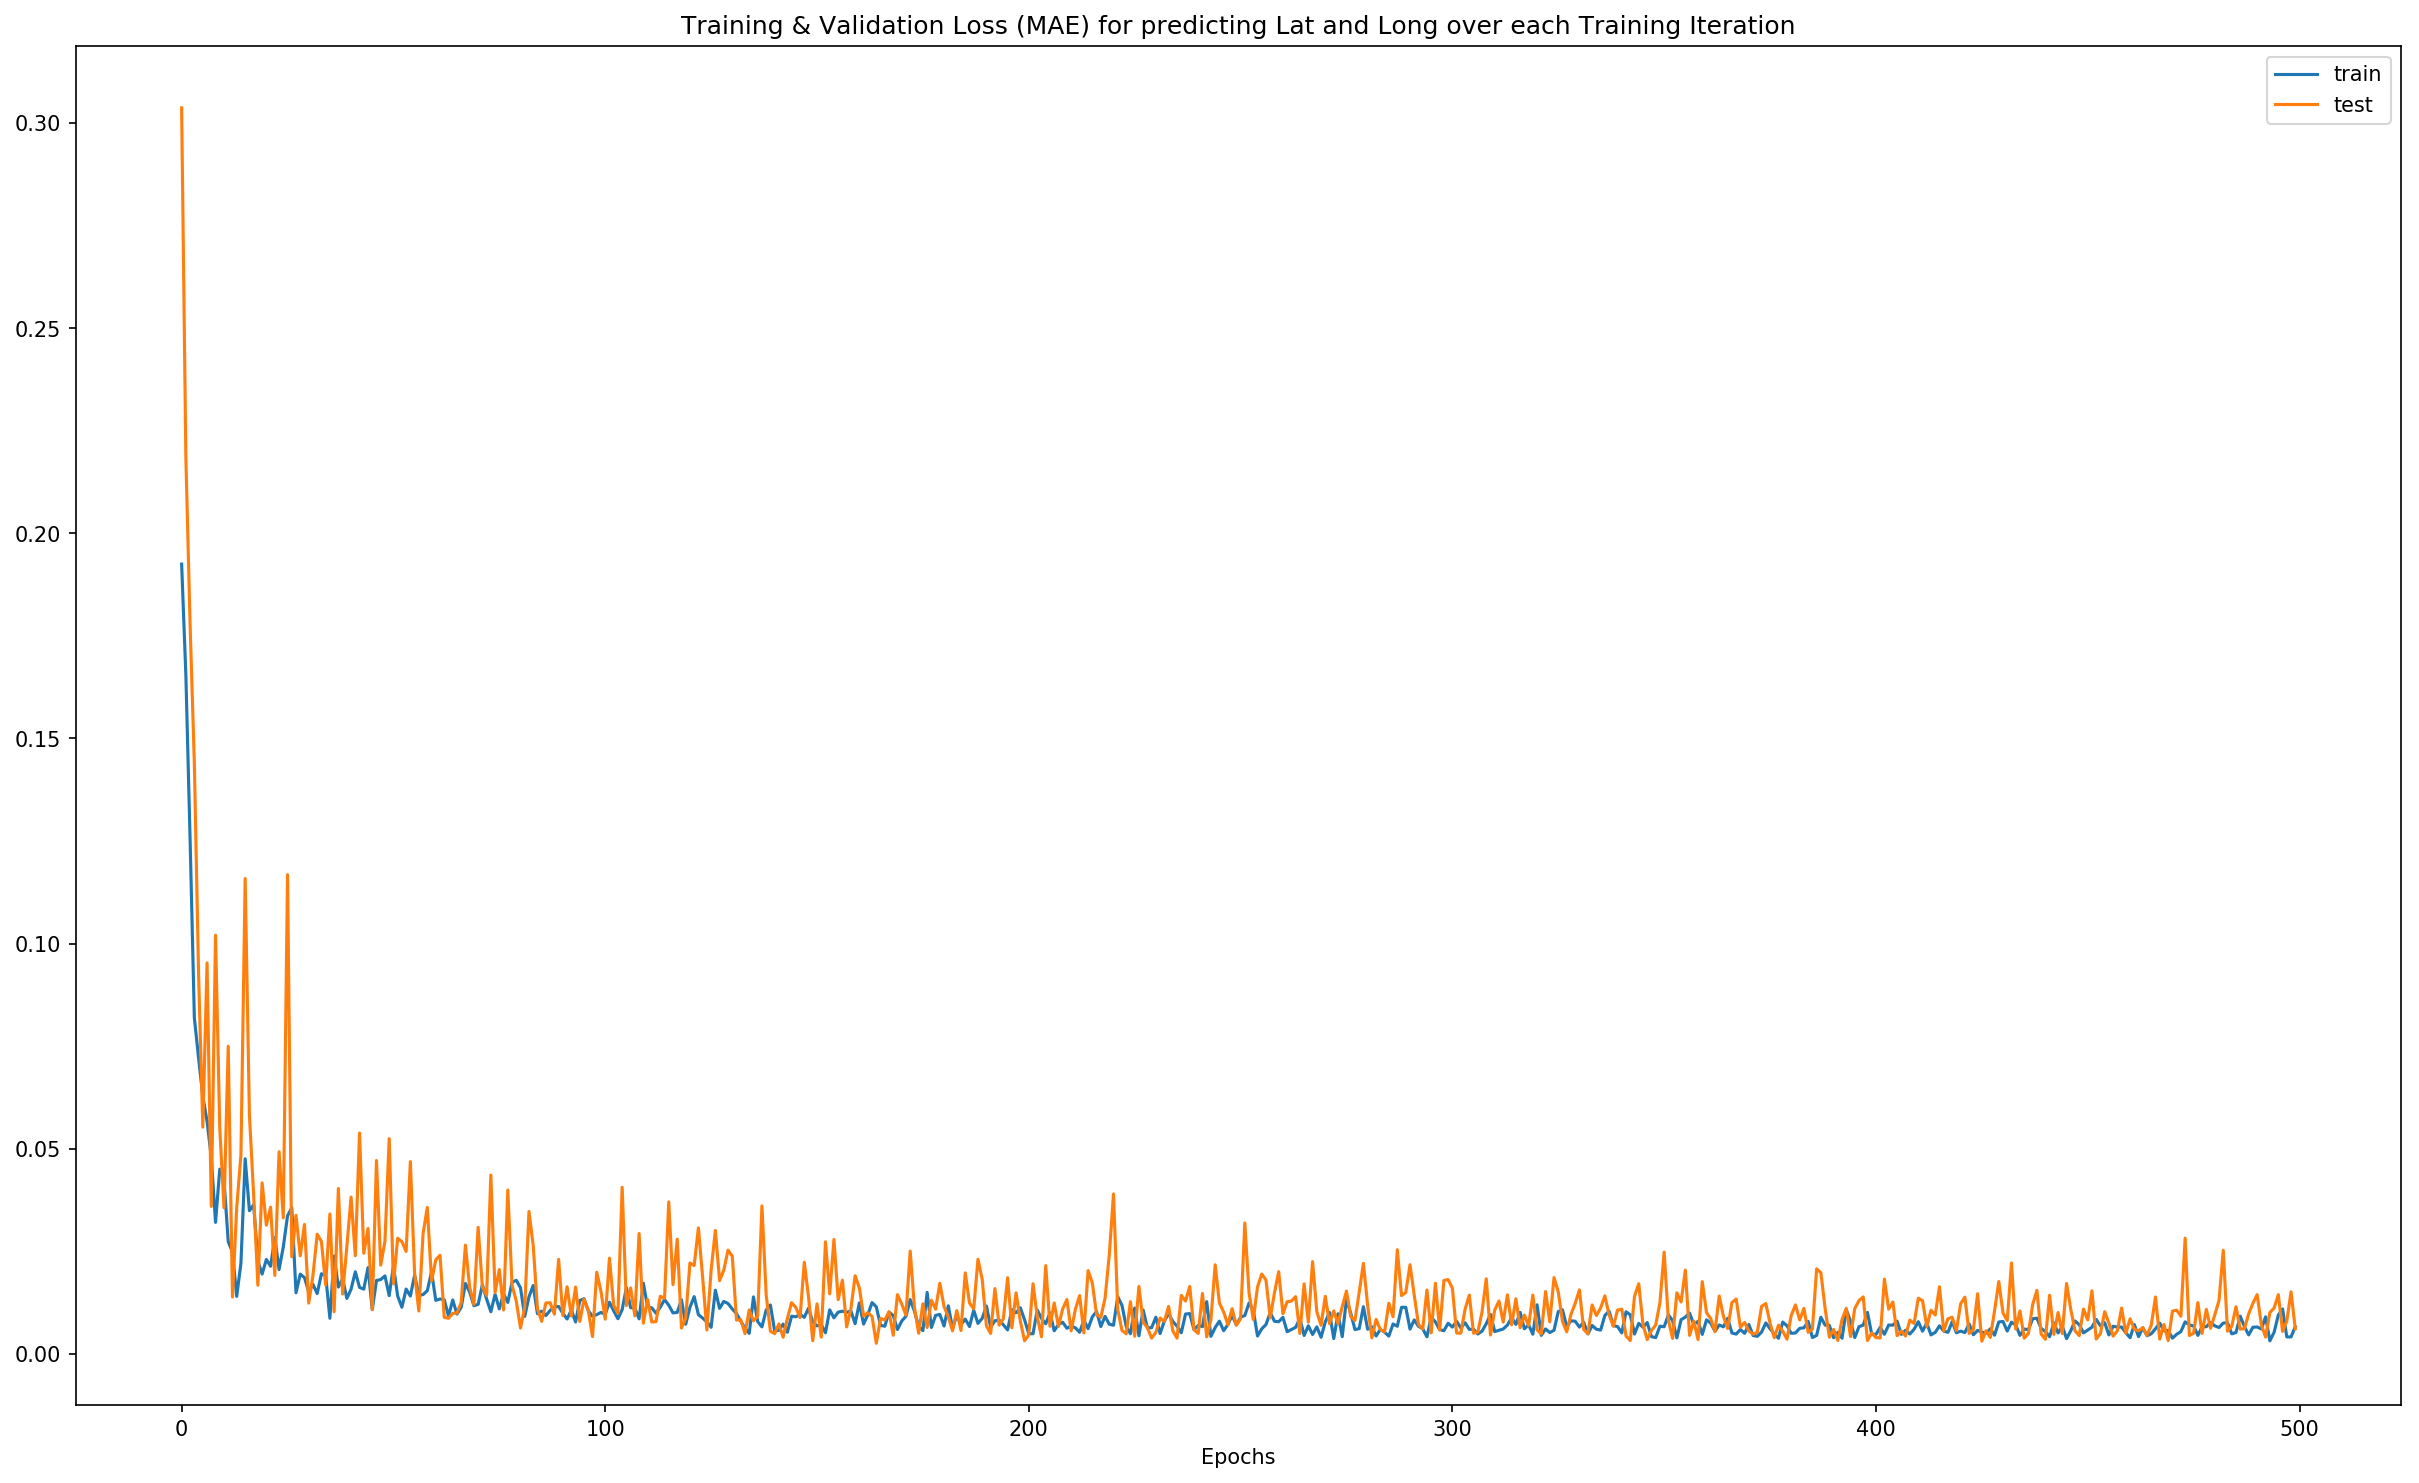

In [27]:
# plot history
plt.figure(figsize=(20,12),dpi=150)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Training & Validation Loss (MAE) for predicting Lat and Long over each Training Iteration')
plt.xlabel('Epochs')
plt.show()

### Make Predictions with Test Data

In [28]:
test_X.shape

(2950, 10, 7)

In [29]:
# make a prediction
yhat = model.predict(test_X)
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat.shape

(2950, 1)

In [30]:
inv_yhat = inv_yhat.flatten()
inv_yhat.shape

(2950,)

In [31]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler_y.inverse_transform(test_y)
inv_y.shape

(2950, 1)

In [32]:
inv_y = inv_y.flatten()
inv_y.shape

(2950,)

In [33]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse, 'in milliseconds (UNIX Epoch Format )')

Test RMSE: 1242014.809 in milliseconds (UNIX Epoch Format )


In [42]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % round(mae/1000), 'seconds')

Test MAE: 314.000 seconds


In [35]:
# pd.set_option('display.float_format', lambda x: '%.1f' % x)
columns = ['PredictedTimestamp(ms)','ActualTimestamp(ms)']
df_from_arr = pd.DataFrame({'PredictedTimestamp(ms)': inv_yhat, 'ActualTimestamp(ms)': inv_y})
df_from_arr['PredictedTimestamp(ms)'] = df_from_arr['PredictedTimestamp(ms)'].apply(np.int64)
df_from_arr['ActualTimestamp(ms)'] = df_from_arr['ActualTimestamp(ms)'].apply(np.int64)
df_from_arr.head(10)

,PredictedTimestamp(ms),ActualTimestamp(ms)
0,1539437887488,1539437756416
1,1539437887488,1539437756416
2,1539437887488,1539437887488
3,1539438018560,1539437887488
4,1539438018560,1539437887488
5,1539438018560,1539437887488
6,1539438018560,1539437887488
7,1539438018560,1539437887488
8,1539438018560,1539437887488
9,1539438018560,1539437887488


In [36]:
df_from_arr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 2 columns):
PredictedTimestamp(ms)    2950 non-null int64
ActualTimestamp(ms)       2950 non-null int64
dtypes: int64(2)
memory usage: 46.2 KB


In [37]:
# Retrieve test data from original flightpaths dataset considering the lag = 10 introduced earlier
flightpaths=flightpaths[(train_test_split_row_nr + 10):].reset_index(drop=True)
flightpaths.info() #Check if it matches with the dimensions (no. of rows) of the predicted dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 9 columns):
postime          2950 non-null int64
aircraftreg      2950 non-null object
icao             2950 non-null int64
lat              2950 non-null float64
lon              2950 non-null float64
alt              2950 non-null int64
course           2950 non-null int64
speed            2950 non-null int64
verticalspeed    2950 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 207.5+ KB


In [38]:
df_from_arr['postime'] = flightpaths.postime.values
df_from_arr['icao'] = flightpaths.icao.values
df_from_arr['aircraftreg'] = flightpaths.aircraftreg.values
df_from_arr['lat'] = flightpaths.lat.values
df_from_arr['lon'] = flightpaths.lon.values
df_from_arr['alt'] = flightpaths.alt.values
df_from_arr['course'] = flightpaths.course.values
df_from_arr['speed'] = flightpaths.speed.values
df_from_arr['verticalspeed'] = flightpaths.verticalspeed.values

In [39]:
df_from_arr.drop(columns=['ActualTimestamp(ms)'],inplace = True)
df_from_arr.rename(columns={"postime": "ActualTimestamp(ms)"}, inplace = True)
df_from_arr['Delta_(P-A)_secs'] = round((df_from_arr['PredictedTimestamp(ms)'] - df_from_arr['ActualTimestamp(ms)'])/1000)
df_from_arr = df_from_arr[['ActualTimestamp(ms)','PredictedTimestamp(ms)','Delta_(P-A)_secs','icao','aircraftreg','lat','lon','alt','course','speed','verticalspeed']]
df_from_arr.head()

,ActualTimestamp(ms),PredictedTimestamp(ms),Delta_(P-A)_secs,icao,aircraftreg,lat,lon,alt,course,speed,verticalspeed
0,1539437807000,1539437887488,80.0,3769770,F-HBNK,48.728519,2.35668,0,180,0,0
1,1539437821000,1539437887488,66.0,3769770,F-HBNK,48.728519,2.35669,0,180,0,0
2,1539437826000,1539437887488,61.0,3769770,F-HBNK,48.728519,2.35668,0,271,0,0
3,1539437837000,1539438018560,182.0,3769770,F-HBNK,48.728512,2.35669,0,89,0,0
4,1539437841000,1539438018560,178.0,3769770,F-HBNK,48.728512,2.35668,0,89,0,0
